# Find moving objects in DECam images
Author: James E. Robinson

Do an initial search for matching images using CADC SSOIS. If the results do not include the image extension that actually contains the target, this notebook can be used to find the object containing the detector. We use a simple minimum separation of detector centre to the target's Horizons ephemeris.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle, Polygon, Wedge
from astropy.io import fits
from astropy import units as u
from astropy import visualization as aviz
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord
from astropy.visualization.wcsaxes import WCSAxes
from astropy.visualization.wcsaxes import Quadrangle
from astropy.wcs import WCS
from astroquery.jplhorizons import Horizons
from astropy.time import Time, TimeDelta
from astroquery.jplhorizons import Horizons

In [2]:
# define target and observatory site
target_name = "C/2020 H5"
site = "807" # Cerro Tololo Inter-American Observatory

In [3]:
# SSOIS provides a link to an image containing the target
# FITS image with corner RA and DEC for each detector:
# fname = "c4d_210601_032202_oki_g_v1.fits.fz" # https://astroarchive.noirlab.edu/api/retrieve/6da9e126efcac2586227a071bb991224
# FITS image without corner RA and DEC (and interesting offsets across detector?)
fname = "c4d_210601_032202_ori.fits.fz" # https://astroarchive.noirlab.edu/api/retrieve/559a284f881dfcd1fd16182c1c29e9ee

In [4]:
# Inspect the full fits file, primary header and detector image extensions
hdu = fits.open(fname)
hdu.info()

Filename: c4d_210601_032202_ori.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     152   ()      
  1  S1            1 CompImageHDU    102   (2160, 4146)   int16   
  2  S2            1 CompImageHDU    102   (2160, 4146)   int16   
  3  S3            1 CompImageHDU    102   (2160, 4146)   int16   
  4  N1            1 CompImageHDU    102   (2160, 4146)   int16   
  5  N2            1 CompImageHDU    102   (2160, 4146)   int16   
  6  N3            1 CompImageHDU    102   (2160, 4146)   int16   
  7  S8            1 CompImageHDU    102   (2160, 4146)   int16   
  8  S9            1 CompImageHDU    102   (2160, 4146)   int16   
  9  S14           1 CompImageHDU    102   (2160, 4146)   int16   
 10  S15           1 CompImageHDU    102   (2160, 4146)   int16   
 11  S20           1 CompImageHDU    102   (2160, 4146)   int16   
 12  S25           1 CompImageHDU    102   (2160, 4146)   int16   
 13  N8            1 CompImageHDU    102   

In [5]:
epoch = Time(hdu[0].header["MJD-OBS"] + ((0.5*hdu[0].header["EXPTIME"])/60/60/24), format = "mjd") # exposure midpoint time
epoch.iso

'2021-06-01 03:22:17.895'

In [6]:
# get object position at mid-point of exposure
obj = Horizons(id=target_name, location = site, epochs = epoch)
eph = obj.ephemerides()
df_eph = eph.to_pandas()
eph_c = SkyCoord(df_eph["RA"], df_eph["DEC"],  unit=(u.deg, u.deg)) # default ICRF/ICRS? But WCS is in fk5?

In [7]:
df_eph

,targetname,datetime_str,datetime_jd,M1,solar_presence,k1,lunar_presence,RA,DEC,RA_app,...,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
0,Robinson (C/2020 H5),2021-Jun-01 03:22:17.895,2.459367e+06,6.7,,8.0,m,183.88262,-29.47192,184.15951,...,8547.6467,0.000046,0.91,3.32,0.057024,8.304,3.029609,5.272,198.8164,-24.5438


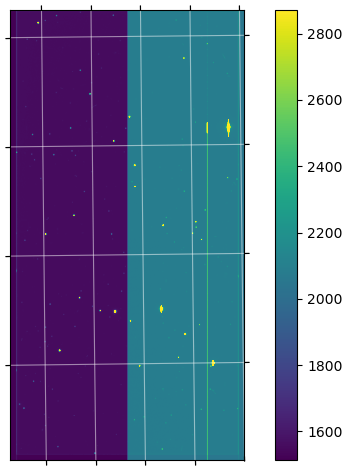

In [8]:
# plot one of the detector images
i_hdu = 1

data = hdu[i_hdu].data
hdr = hdu[i_hdu].header
wcs = WCS(hdr)

plot_img = data
plot_wcs = wcs

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
# ax1 = plt.subplot(gs[0,0]) # regular pixel plot
ax1 = plt.subplot(gs[0,0], projection = plot_wcs) # wcs projection plot
ax1.coords.grid(color="white", alpha=0.5, linestyle="solid") # wcs projection plot

norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
cbar = plt.colorbar(s1)

plt.tight_layout()

plt.show()

In [9]:
data.shape

(4146, 2160)

In [10]:
# get image vertices in pixel coords
lenx = data.shape[1] - 1
leny = data.shape[0] - 1
x1 = (0,0)
x2 = (lenx,0)
x3 = (0,leny)
x4 = (lenx,leny)

vert_pix = [x2,x1,x3,x4]

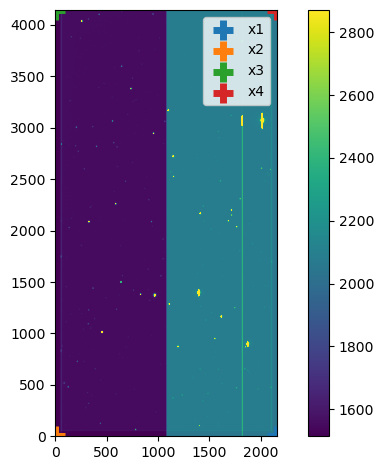

In [11]:
# plot the detector image and pixel corner coordinates
plot_img = data
plot_wcs = wcs

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
cbar = plt.colorbar(s1)

for i,_x in enumerate(vert_pix):
    ax1.scatter(_x[0],_x[1], marker = "+", label = "x{}".format(i+1), s = 200, lw = 5)

ax1.legend()
plt.tight_layout()

plt.show()

In [12]:
# get image vertices in SkyCoords
vert_wcs = pixel_to_skycoord(np.array(vert_pix)[:,0],np.array(vert_pix)[:,1],wcs = wcs)

In [13]:
vert_wcs

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(183.09210317, -28.59993339), (183.09436878, -28.44229393),
     (183.4377416 , -28.44550229), (183.43594701, -28.6033125 )]>

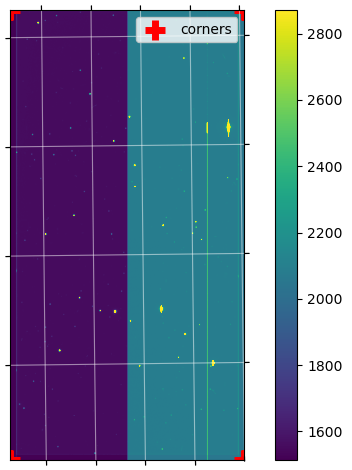

In [14]:
# plot the detector image and wcs corner coordinates
plot_img = data
plot_wcs = wcs

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0], projection = plot_wcs)
ax1.coords.grid(color="white", alpha=0.5, linestyle="solid")

norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
cbar = plt.colorbar(s1)

ax1.scatter(vert_wcs.ra,vert_wcs.dec, transform=ax1.get_transform('world'), c = "r", label = "corners".format(i+1),
           marker = "+", s = 200, lw = 5)

ax1.legend()
plt.tight_layout()

plt.show()

In [15]:
# NB it is simpler to just get the detector coordinates from the header directly

In [16]:
# primary header
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NEXTEND =                   70 / Number of extensions                           
PROCTYPE= 'raw     '           / Data processing level                          
PRODTYPE= 'image   '           / Data product type                              
DETSIZE = '[1:29400,1:29050]'  / Detector size                                  
PIXSCAL1=                 0.27 / [arcsec/pixel] Pixel scale, axis 1             
PIXSCAL2=                 0.27 / [arcsec/pixel] Pixel scale, axis 2             
FILENAME= 'DECam_01003831.fits' / Filename                                      
OBS-LONG=    70.81489000000001 / [deg] Observatory east longitude               
TELESCOP= 'CTIO 4.0-m telesc

In [17]:
# detector header
hdu[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2160 / length of data axis 1                          
NAXIS2  =                 4146 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
BUNIT   = 'adu     '           / Brightness units for pixel array               
WCSAXES =                    2 / WCS Dimensionality                             
DETSIZE = '[1:29400,1:29050]'  / Detector size                                  
TRIMSEC = '[57:2104,51:4146]'  / Good section                                   
DATASEC = '[57:2104,51:4146]'  / Data section to display                        
DETSEC  = '[12289:14336,1:40

In [18]:
hdu[2].header["EXTNAME"]

'S2'

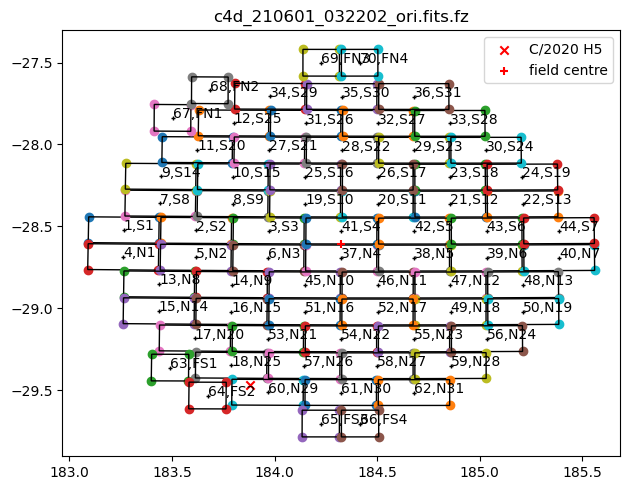

In [19]:
# plot the positions of each detector
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])

det_centres = []
for i_hdu in range(1,len(hdu)):
    
    data = hdu[i_hdu].data
    hdr = hdu[i_hdu].header

    if "COR2RA1" not in list(hdr):
        # get image vertices in pixel coords
        wcs = WCS(hdr)
        lenx = data.shape[1] - 1
        leny = data.shape[0] - 1
        x1 = (0,0)
        x2 = (lenx,0)
        x3 = (0,leny)
        x4 = (lenx,leny)
        vert_pix = [x2,x1,x3,x4]
        c_corner = pixel_to_skycoord(np.array(vert_pix)[:,0],np.array(vert_pix)[:,1],wcs = wcs)      

        # get the detector centre coordinates
        c_centre = pixel_to_skycoord(lenx/2.0,leny/2.0,wcs = wcs)
    else:        
        # Get the detector corner coordinates, NB the order matters when plotting the polygon
        ra_corners = np.array([hdr["COR2RA1"],hdr["COR1RA1"],hdr["COR3RA1"],hdr["COR4RA1"]])
        dec_corners = np.array([hdr["COR2DEC1"],hdr["COR1DEC1"],hdr["COR3DEC1"],hdr["COR4DEC1"]])
        c_corner = SkyCoord(ra_corners, dec_corners, unit = (u.deg,u.deg))

        # get the detector centre coordinates
        c_centre = SkyCoord(ra = hdr["CENRA1"], dec = hdr["CENDEC1"],unit=(u.deg, u.deg))

    # plot the detector corners
    ax1.scatter(c_corner.ra,c_corner.dec)#, label = "{}".format(hdr["EXTNAME"]))

    # plot the detector centre coordinates
    ax1.scatter(c_centre.ra,c_centre.dec, c = "k", marker = "+", s =5, lw = 1)
    ax1.text(c_centre.ra.value,c_centre.dec.value, "{},{}".format(i_hdu,hdr["EXTNAME"]))

    # plot a polygon approximating the detector's extent on the sky
    # NB this does not account for spherical geometry
    poly_verts = np.array([c_corner.ra,c_corner.dec]).T
    polygon = Polygon(poly_verts, closed=True, fill = None)
    ax1.add_patch(polygon)

    det_centres.append(c_centre)

# plot the target position
ax1.scatter(eph_c.ra,eph_c.dec, marker = "x", c = "r", label = "{}".format(target_name))

# plot the centre of the field of view
c_pointing = SkyCoord(ra = hdu[0].header["RA"], dec = hdu[0].header["DEC"], unit=(u.hourangle, u.deg))
ax1.scatter(c_pointing.ra,c_pointing.dec, marker = "+", c = "r", label = "field centre")

ax1.legend()
plt.tight_layout()
plt.title(fname)

plt.show()

In [20]:
# find the nearest detector to the target
sep_list = []
i_hdu_list = []
for j,i_hdu in enumerate(range(1,len(hdu))):

    hdr = hdu[i_hdu].header

    # c_centre = SkyCoord(ra = hdr["CENRA1"], dec = hdr["CENDEC1"],unit=(u.deg, u.deg))
    c_centre = det_centres[j]
    sep = eph_c.separation(c_centre)
    sep_list.append(sep)
    i_hdu_list.append(i_hdu)

# retrieve the hdu index of the nearest detector
i_hdu_min = i_hdu_list[np.argmin(sep_list)]
np.amin(sep_list), i_hdu_min, hdu[i_hdu_min].header["EXTNAME"]

(0.08362580688108219, 60, 'N29')

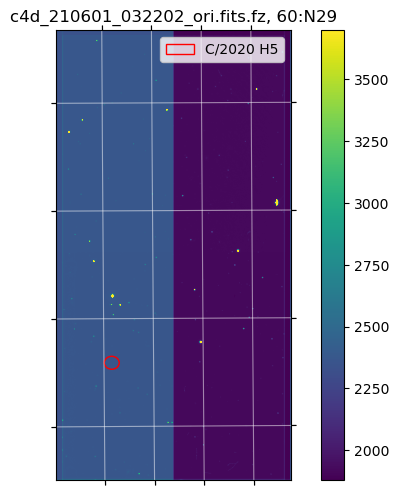

In [21]:
# plot the nearest detector to the target
data = hdu[i_hdu_min].data
hdr = hdu[i_hdu_min].header
wcs = WCS(hdr)

plot_img = data
plot_wcs = wcs

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0], projection = plot_wcs)
ax1.coords.grid(color="white", alpha=0.5, linestyle="solid")

norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
s1 = ax1.imshow(plot_img, norm=norm, origin='lower')
cbar = plt.colorbar(s1)

# plot the target position
# ax1.scatter(eph_c.ra,eph_c.dec, marker = "x", c = "r", transform=ax1.get_transform('world'), label = "{}".format(target_name))
c = Circle((eph_c.ra.value,eph_c.dec.value), 0.005, edgecolor='red', facecolor='none',
           transform=ax1.get_transform('world'), label = target_name)
ax1.add_patch(c)

ax1.legend()
plt.tight_layout()
plt.title("{}, {}:{}".format(fname,i_hdu_min,hdr["EXTNAME"]))

plt.show()

In [22]:
# TODO: Check if a point lies within a polygon accounting for spherical geometry of sky coordinates
# NB astropy wcs quadrangle assumes lines of constant longitude/latitude, not suitable for rotated detectors
# conda install of regions package (polygon) has a mac compatibility issue? https://astropy-regions.readthedocs.io/en/stable/contains.html
# try lsst.geom?